# **Food Deserts and Fast Food Hot Spots**

In [36]:
# Import Neccessary Libraries 
import pandas as pd
import numpy as np
import geopandas as gpd 
import os
from census import Census
from us import states
from sklearn.impute import KNNImputer

### 1) Load, Preprocess, and Clean data

In [54]:
# set working env 
# Stella's env: 
os.chdir('/Users/stellameserve/Documents/GW/senior_yr/Semester_8/GEOG_3198/Final_Project')
# Maryana's env: 
# os.chdir('')

# Load in neccessary Data
# all data is in a folder within the working env called "data"
philly_aoi = gpd.read_file('data/philly_aoi')
fast_food = gpd.read_file('data/fast_food.geojson')
grocery = gpd.read_file('data/grocery_stores.geojson')
transit = gpd.read_file('data/Transit_Stops.geojson')
census_blocks = gpd.read_file('data/Census_Block_Groups_2020')
parks = gpd.read_file('data/PPR_Properties.geojson')
water_bodies = gpd.read_file('data/Hydrographic_Features_Poly')

# set the CRS to EPSG:32618 which is UTM 18 
philly_aoi = philly_aoi.to_crs('EPSG:32618')
fast_food = fast_food.to_crs('EPSG:32618')
grocery = grocery.to_crs('EPSG:32618')          
transit = transit.to_crs('EPSG:32618')   
census_blocks = census_blocks.to_crs('EPSG:32618')      
parks = parks.to_crs('EPSG:32618')   
water_bodies = water_bodies.to_crs('EPSG:32618')           

#### A) Handle the Census Data

In [25]:
# activate session 
session = Census('f343a55292f63d05fc254dca9cf906764e18b565')

# Pennsylvania (42) and Philadelphia County (101)
state_fips = '42'
county_fips = '101'

# variables we want 
variables = {
    'poverty_total': 'B17001_001E',
    'poverty_below': 'B17001_002E',
    'no_vehicle': 'B08201_002E',
    'total_households': 'B08201_001E',
    'median_income': 'B19013_001E',
    '35_income_rent': 'B25070_007E'
}

In [27]:
# Request ACS data for all tracts in Philadelphia
results = session.acs5.state_county_tract(
    list(variables.values()),
    state_fips = state_fips,
    county_fips = county_fips,
    tract = "*"
)

In [29]:
# Convert to df
census_ind = pd.DataFrame(results)

# Rename columns
census_ind = census_ind.rename(columns={
    'B17001_001E': 'poverty_total',
    'B17001_002E': 'poverty_below',
    'B08201_002E': 'no_vehicle',
    'B08201_001E': 'total_households',
    'B19013_001E': 'median_income',
    'B25070_007E': '35_income_rent',
    'state': 'state_fips',
    'county': 'county_fips',
    'tract': 'tract_fips'
})

In [30]:
# calc missing variables
census_ind['pct_below_poverty'] = census_ind['poverty_below'].astype(float) / census_ind['poverty_total'].astype(float)
census_ind['pct_no_vehicle'] = census_ind['no_vehicle'].astype(float) / census_ind['total_households'].astype(float)

In [32]:
# create a GEOID column in the census df 
census_ind['GEOID'] = census_ind['state_fips'] + census_ind['county_fips'] + census_ind['tract_fips']

# GEOID in the census shp has BLKGRPCE in the GEOID which we don't need 
# remove the last BLKGRPCE number from GEOID 
census_blocks['GEOID'] = census_blocks['GEOID'].str[:-1]


In [62]:
# join the tablar data to the geodataframe  
census = census_blocks.merge(census_ind, on='GEOID', how='left')

In [38]:
# there are some null values 
# census uses -666666666.0 as null so im going to set that to null so we can handle it 
census.replace(-666666666.0, np.nan, inplace=True)

# Check for NaNs
print("NaN counts before imputation:")
print(census.isna().sum())


NaN counts before imputation:
OBJECTID              0
STATEFP               0
COUNTYFP              0
TRACTCE               0
BLKGRPCE              0
GEOID                 0
NAMELSAD              0
MTFCC                 0
FUNCSTAT              0
ALAND                 0
AWATER                0
INTPTLAT              0
INTPTLON              0
Shape__Are            0
Shape__Len            0
geometry              0
poverty_total         0
poverty_below         0
no_vehicle            0
total_households      0
median_income        65
35_income_rent        0
state_fips            0
county_fips           0
tract_fips            0
pct_below_poverty    44
pct_no_vehicle       48
dtype: int64


In [39]:
# imputate the missing data with KNN

# Select numeric columns
columns_to_impute = census.select_dtypes(include=[np.number]).columns.tolist()

# Fit KNN on df (including complete rows)
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(census[columns_to_impute])

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed, columns=columns_to_impute, index=census.index)

# Only fill in NaNs - non missing original values are untouched 
for col in columns_to_impute:
    census[col] = census[col].combine_first(imputed_df[col])

# Check for NaNs after imputation
print("NaN counts after imputation:")
print(census.isna().sum())

NaN counts after imputation:
OBJECTID             0
STATEFP              0
COUNTYFP             0
TRACTCE              0
BLKGRPCE             0
GEOID                0
NAMELSAD             0
MTFCC                0
FUNCSTAT             0
ALAND                0
AWATER               0
INTPTLAT             0
INTPTLON             0
Shape__Are           0
Shape__Len           0
geometry             0
poverty_total        0
poverty_below        0
no_vehicle           0
total_households     0
median_income        0
35_income_rent       0
state_fips           0
county_fips          0
tract_fips           0
pct_below_poverty    0
pct_no_vehicle       0
dtype: int64


/var/folders/z8/fsnb0vqj3vl1nxm67jdylbwh0000gn/T/ipykernel_73125/1007722528.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  census[col] = census[col].combine_first(imputed_df[col])


#### B) Clean the Waterbodies and Parks

<Axes: >

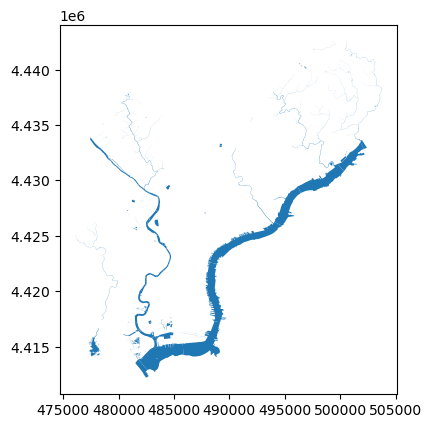

In [63]:
# only select rivers in the philadelphia city municipality 
phil_water_bodies = water_bodies[water_bodies['muni'] == 'Philadelphia city']
phil_water_bodies.plot()

<Axes: >

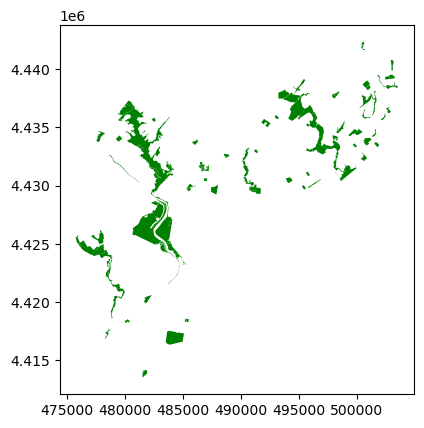

In [70]:
# Clean the Parks by removing parks that are small

parks = parks[parks['Shape__Area'] > 100000] # so not confident as to what this number is. Maybe meters squared? acres? just did it until the small ones were gone 

#explore 
parks.plot(color='green')

### 3) Remove Parks and Water bodies from Philadelphia SHP

In [71]:
# Create a single geometry of all parks and water
parks_union = parks.unary_union
water_union = water_bodies.unary_union

/var/folders/z8/fsnb0vqj3vl1nxm67jdylbwh0000gn/T/ipykernel_73125/1360192898.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  parks_union = parks.unary_union
/opt/anaconda3/envs/geowombat/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/z8/fsnb0vqj3vl1nxm67jdylbwh0000gn/T/ipykernel_73125/1360192898.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  water_union = water_bodies.unary_union


In [78]:
# Subtract parks from each census geometry 
census_without_parks = census.copy()
census_without_parks['geometry'] = census_without_parks.geometry.difference(parks_union)

# remove water bodies
census_without_parks['geometry'] = census_without_parks.geometry.difference(water_union)
census_clean= census_without_parks.copy()

/opt/anaconda3/envs/geowombat/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


In [79]:
# Census without the parks or waterbodies 
census_clean.explore()

In [80]:
# Save this as a shapefile so we don't have to rerun everything
census_clean.to_file("data/census_cleaned.shp")

/var/folders/z8/fsnb0vqj3vl1nxm67jdylbwh0000gn/T/ipykernel_73125/3346913451.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  census_clean.to_file("data/census_cleaned.shp")
/opt/anaconda3/envs/geowombat/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'poverty_total' to 'poverty_to'
  ogr_write(
/opt/anaconda3/envs/geowombat/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'poverty_below' to 'poverty_be'
  ogr_write(
/opt/anaconda3/envs/geowombat/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_households' to 'total_hous'
  ogr_write(
/opt/anaconda3/envs/geowombat/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'median_income' to 'median_inc'
  ogr_write(
/opt/anaconda3/envs/geowombat/lib/python3.11/site-packages/pyogrio/raw.py

## 2) Food Desert Analysis 